In [1]:
# Импорт библиотек
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from minisom import MiniSom
from sklearn.metrics import silhouette_score

# Загрузка и просмотр датасета
df = pd.read_csv("russia_alcohol.csv")

df.head(5)

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [2]:
# Проверка значений
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


year          0
region        0
wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64

In [3]:
# Обработка пропущенных значений
df_colums = ["wine", "beer", "vodka", "champagne", "brandy"]
df[df_colums] = df[df_colums].fillna(df[df_colums].mean())

df.isna().sum()

year         0
region       0
wine         0
beer         0
vodka        0
champagne    0
brandy       0
dtype: int64

In [4]:
# Группировка по регионам
df_group = df.groupby("region")[df_colums].mean()

df_group.head(5)

,wine,beer,vodka,champagne,brandy
region,,,,,
Altai Krai,3.174211,48.373158,9.465789,1.207368,0.236842
Altai Republic,5.190000,36.724211,9.683684,0.934737,0.253684
Amur Oblast,5.221579,53.377368,14.216842,1.115789,0.396842
Arkhangelsk Oblast,8.670000,47.036842,17.381053,1.631053,0.870526
Astrakhan Oblast,4.469474,54.695263,9.296842,0.861579,0.361053


In [5]:
# Нормализация
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_group[df_colums])

#df_scaled

In [6]:
# Инициализация SOM
n = 10

model = MiniSom(x=n, 
                y=n, 
                input_len=len(df_colums),
                sigma=2, 
                learning_rate=16,
                random_seed=0)

# Обучение SOM
model.train(df_scaled, num_iteration=1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.25436030567979556


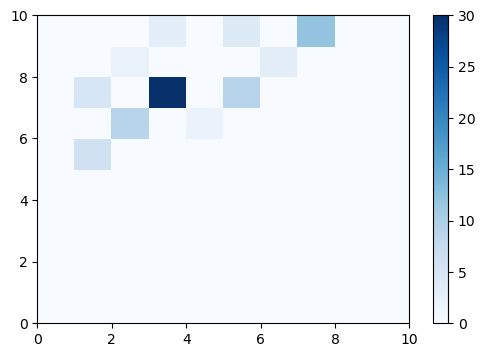

In [43]:
# Топографическая карта
df_scaled = pd.DataFrame(df_scaled, columns=df_group.columns, index=df_group.index)

plt.figure(figsize=(6, 4))
frequencies = model.activation_response(df_scaled.values)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

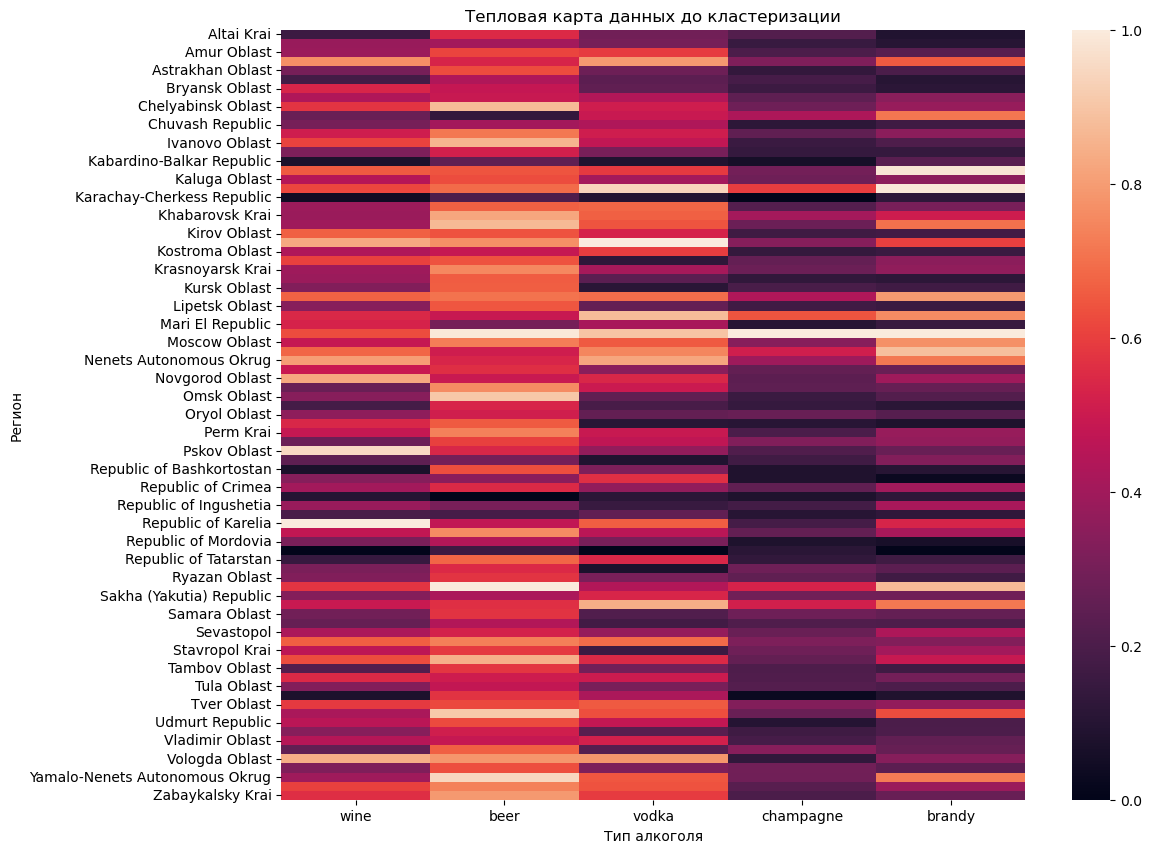

In [8]:
# Визуализация тепловой карты данных до кластеризации
plt.figure(figsize=(12, 10))
sns.heatmap(df_scaled)
plt.title("Тепловая карта данных до кластеризации")
plt.xlabel("Тип алкоголя")
plt.ylabel("Регион")

plt.show()

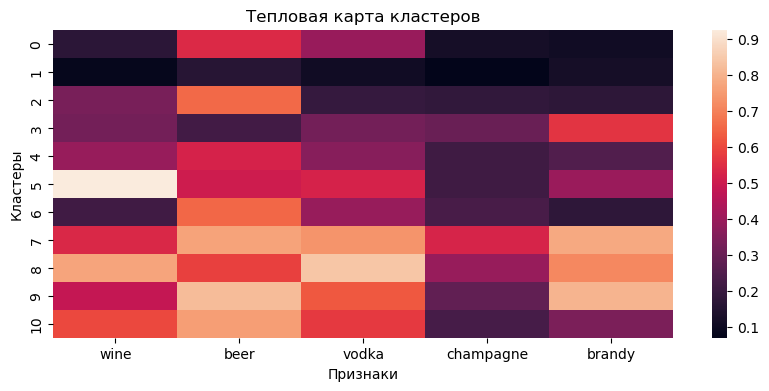

In [9]:
# Визуализация тепловой карты данных после кластеризации
n_winners = [tuple(model.winner(x)) for x in df_scaled.values]
n_unique = {x: i for i, x in enumerate(sorted(set(n_winners)))}

cluster_labels = [n_unique[x] for x in n_winners]

df_clusters = df_scaled.copy()
df_clusters["cluster"] = cluster_labels

heatmap = df_clusters.groupby("cluster").mean()

plt.figure(figsize=(10, 4))
sns.heatmap(heatmap)
plt.title("Тепловая карта кластеров")
plt.xlabel("Признаки")
plt.ylabel("Кластеры")

plt.show()

In [10]:
#(df_clusters["cluster"].value_counts(), 
#len(df_clusters["cluster"].value_counts()),

df_clusters.sort_values(by="cluster", ascending=True)

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Belgorod Oblast,0.176704,0.430744,0.240497,0.185195,0.103578,0
Republic of Buryatia,0.336660,0.350131,0.562930,0.084121,0.028719,0
Republic of Bashkortostan,0.072479,0.631221,0.318057,0.085156,0.104520,0
Tambov Oblast,0.217962,0.580220,0.295377,0.206290,0.164313,0
Republic of Tatarstan,0.145833,0.676663,0.541252,0.130581,0.166196,0
...,...,...,...,...,...,...
Sverdlovsk Oblast,0.625292,0.844273,0.550003,0.255986,0.491525,10
Smolensk Oblast,0.661473,0.731202,0.689124,0.318623,0.328154,10
Yaroslavl Oblast,0.604283,0.736067,0.637618,0.226608,0.385593,10


In [11]:
df_clusters.loc[df_clusters["cluster"] == 1]

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Kabardino-Balkar Republic,0.075514,0.249681,0.088950,0.061861,0.232109,1
Karachay-Cherkess Republic,0.041667,0.203639,0.097602,0.000000,0.121469,1
Republic of Dagestan,0.098915,0.000000,0.115338,0.079073,0.118173,1
Republic of Kalmykia,0.191702,0.186720,0.251921,0.104310,0.125235,1
Republic of North Ossetia-Alania,0.000000,0.160480,0.000000,0.110133,0.000000,1


In [ ]:
# Проверка методом Kmeans
kmeans = KMeans(n_clusters=11, random_state=0)
kmeans_labels = kmeans.fit_predict(df_scaled.values)

df_kmeans = df_scaled.copy()
df_kmeans["cluster"] = kmeans_labels

kmeans_summary = df_kmeans.groupby("cluster").mean()

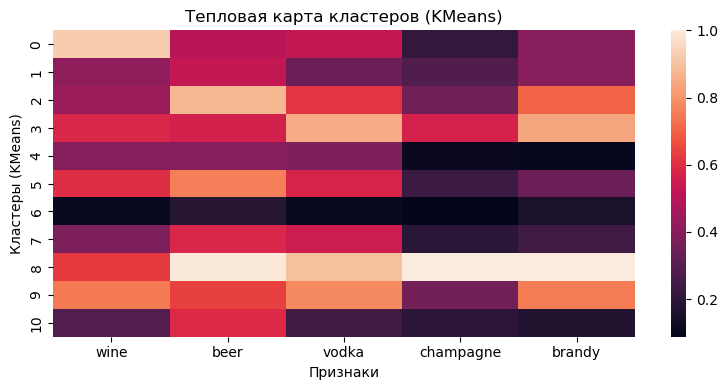

In [33]:
# Тепловая карта
plt.figure(figsize=(8, 4))
sns.heatmap(kmeans_summary)
plt.title("Тепловая карта кластеров (KMeans)")
plt.xlabel("Признаки")
plt.ylabel("Кластеры (KMeans)")
plt.tight_layout()
plt.show()

In [14]:
df_kmeans.sort_values(by="cluster", ascending=True)

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Republic of Karelia,1.000000,0.472972,0.663638,0.182477,0.533898,0
Novgorod Oblast,0.825105,0.494313,0.539582,0.241232,0.395480,0
Pskov Oblast,0.949638,0.539135,0.365923,0.209913,0.268362,0
Stavropol Krai,0.467729,0.586564,0.156958,0.281351,0.403955,1
Krasnodar Krai,0.604283,0.639248,0.122988,0.261680,0.351224,1
...,...,...,...,...,...,...
Jewish Autonomous Oblast,0.318277,0.516665,0.307369,0.144170,0.143126,10
Belgorod Oblast,0.176704,0.430744,0.240497,0.185195,0.103578,10
Astrakhan Oblast,0.302288,0.627749,0.279210,0.133299,0.197740,10


In [15]:
df_clusters.loc[df_clusters["cluster"] == 1]

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Kabardino-Balkar Republic,0.075514,0.249681,0.088950,0.061861,0.232109,1
Karachay-Cherkess Republic,0.041667,0.203639,0.097602,0.000000,0.121469,1
Republic of Dagestan,0.098915,0.000000,0.115338,0.079073,0.118173,1
Republic of Kalmykia,0.191702,0.186720,0.251921,0.104310,0.125235,1
Republic of North Ossetia-Alania,0.000000,0.160480,0.000000,0.110133,0.000000,1


In [16]:
som_silhouette = silhouette_score(df_scaled.values, cluster_labels)
kmeans_silhouette = silhouette_score(df_scaled.values, kmeans_labels)

print(f"Метрика силуэта для сети Кохонена: {som_silhouette:.4f}")
print(f"Метрика силуэта для K-Means: {kmeans_silhouette:.4f}\n")

Метрика силуэта для сети Кохонена: 0.1164
Метрика силуэта для K-Means: 0.2443

